**LAND PRICE PREDICTION USING MACHINE LEARNING**

This project predicts land prices in Bengaluru based on location, land size, and price trends

**STEP 1: INSTALL DEPENDENCIES**

In [11]:
# Tools for data handling, ML, and visualization
!pip install pandas numpy scikit-learn category_encoders matplotlib seaborn

**STEP 2: IMPORT LIBRARIES**

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

**STEP 3: LOAD & INSPECT DATA**

In [15]:
# Load dataset
print("\nLoading data...")
df = pd.read_csv('/Bengaluru_House_Data.csv')

# Keep only relevant columns: location, land size, and price
df = df[['location', 'total_sqft', 'price']]
print("\nRaw Data Sample:")
print(df.head(3))

print("\nDataset Info:")
print(df.info())


Loading data...

Raw Data Sample:
                   location total_sqft   price
0  Electronic City Phase II       1056   39.07
1          Chikka Tirupathi       2600  120.00
2               Uttarahalli       1440   62.00

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   total_sqft  13320 non-null  object 
 2   price       13320 non-null  float64
dtypes: float64(1), object(2)
memory usage: 312.3+ KB
None


**STEP 4: CLEAN 'total_sqft' COLUMN**

In [17]:
print("\nCleaning 'total_sqft' column...")

def clean_total_sqft(sqft):
    """Converts complex entries to numeric sqft values"""
    if isinstance(sqft, str):
        # Handle ranges like "1000-1500"
        if '-' in sqft:
            parts = sqft.split('-')
            try:
                return (float(parts[0]) + float(parts[1])) / 2
            except:
                return np.nan

        # Extract numeric value from strings
        match = re.search(r'(\d+\.?\d*)', sqft)
        if match:
            numeric_value = float(match.group(1))
            unit = sqft.lower()

            # Convert different units to sqft
            conversions = {
                'acre': 43560,
                'perch': 272.25,
                'cent': 435.6,
                'sq.m': 10.7639,
                'sq.yd': 9
            }
            for unit_key, multiplier in conversions.items():
                if unit_key in unit:
                    return numeric_value * multiplier
            return numeric_value  # Default to sqft
        else:
            return np.nan
    else:
        return float(sqft)

# Apply cleaning
initial_count = len(df)
df['total_sqft'] = df['total_sqft'].apply(clean_total_sqft)
df = df.dropna(subset=['total_sqft', 'price'])
print(f"\nRemoved {initial_count - len(df)} invalid rows")
print("\nCleaned Data Sample:")
print(df.head(3))


Cleaning 'total_sqft' column...

Removed 0 invalid rows

Cleaned Data Sample:
                   location  total_sqft   price
0  Electronic City Phase II      1056.0   39.07
1          Chikka Tirupathi      2600.0  120.00
2               Uttarahalli      1440.0   62.00


**STEP 5: EXPLORATORY ANALYSIS**


Exploratory Data Analysis:


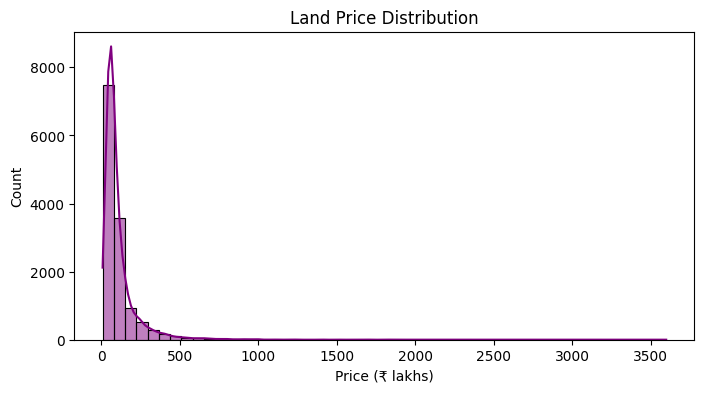

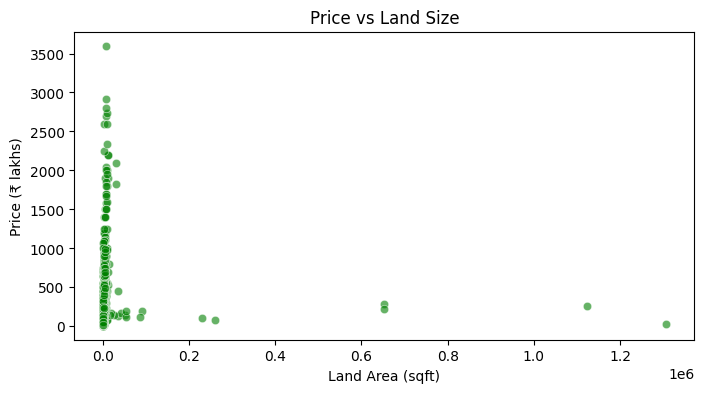

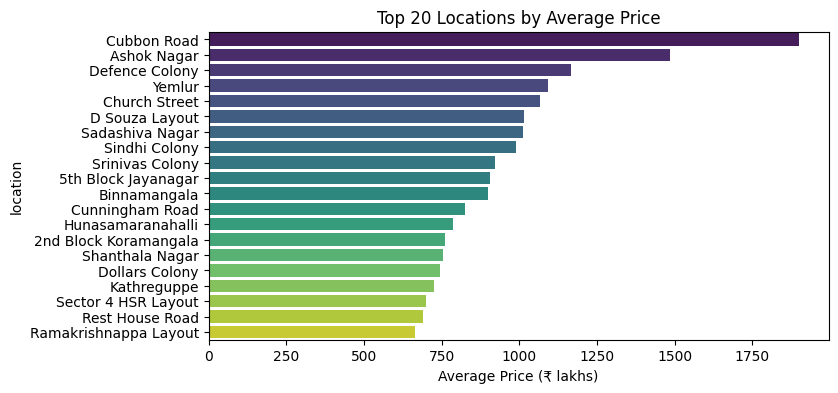

In [19]:
print("\nExploratory Data Analysis:")

# Plot 1: Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=50, kde=True, color='purple')
plt.title('Land Price Distribution')
plt.xlabel('Price (₹ lakhs)')
plt.ylabel('Count')
plt.show()

# Plot 2: Price vs Land Size
plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_sqft', y='price', data=df, alpha=0.6, color='green')
plt.title('Price vs Land Size')
plt.xlabel('Land Area (sqft)')
plt.ylabel('Price (₹ lakhs)')
plt.show()

# Plot 3: Top 20 Locations by Average Price
plt.figure(figsize=(8, 4))
top_locations = df.groupby('location')['price'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis',hue=top_locations.index)
plt.title('Top 20 Locations by Average Price')
plt.xlabel('Average Price (₹ lakhs)')
plt.show()

**STEP 6: ENCODE LOCATIONS**

In [20]:
print("\nEncoding location names...")

encoder = TargetEncoder()
df['location_encoded'] = encoder.fit_transform(df['location'], df['price'])
print("\nEncoded Data Sample:")
print(df[['location', 'location_encoded']].head(3))


Encoding location names...

Encoded Data Sample:
                   location  location_encoded
0  Electronic City Phase II         48.317545
1          Chikka Tirupathi        113.608351
2               Uttarahalli         61.252530


**STEP 7: PREPARE DATA FOR MODELING**

In [21]:
print("\nPreparing data for machine learning...")

X = df[['total_sqft', 'location_encoded']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nData Splits:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Preparing data for machine learning...

Data Splits:
Training samples: 10656
Test samples: 2664


**STEP 8: BUILD & TRAIN MODEL**

In [22]:
print("\nBuilding and training model...")

model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ))
])

# Cross-validation
print("\nRunning cross-validation...")
cv_scores = cross_val_score(model, X_train, y_train,
                           scoring='neg_root_mean_squared_error',
                           cv=5)
print(f"Cross-Validation RMSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Final training
model.fit(X_train, y_train)
print("\nModel training complete!")



Building and training model...

Running cross-validation...
Cross-Validation RMSE: 78.94 ± 3.45

Model training complete!


**STEP 9: EVALUATE MODEL**


Evaluating model performance...

Final Test RMSE: ₹63.83 lakhs


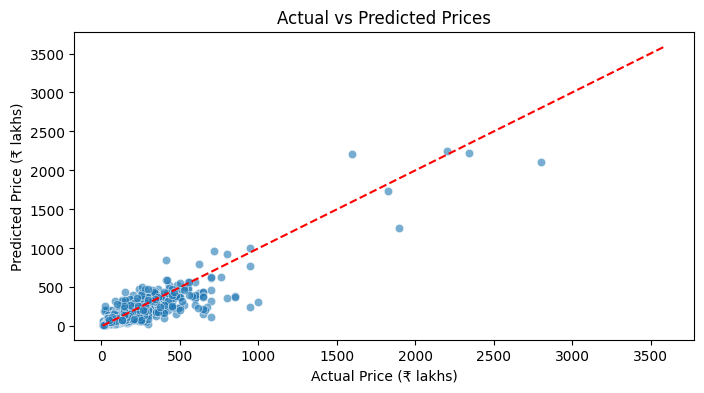

In [24]:
print("\nEvaluating model performance...")

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nFinal Test RMSE: ₹{rmse:.2f} lakhs")

# Plot predictions vs actual
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price (₹ lakhs)')
plt.ylabel('Predicted Price (₹ lakhs)')
plt.show()

**STEP 10: FEATURE IMPORTANCE**


Analyzing feature importance...


<ipython-input-26-7ad616614546>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette='rocket')


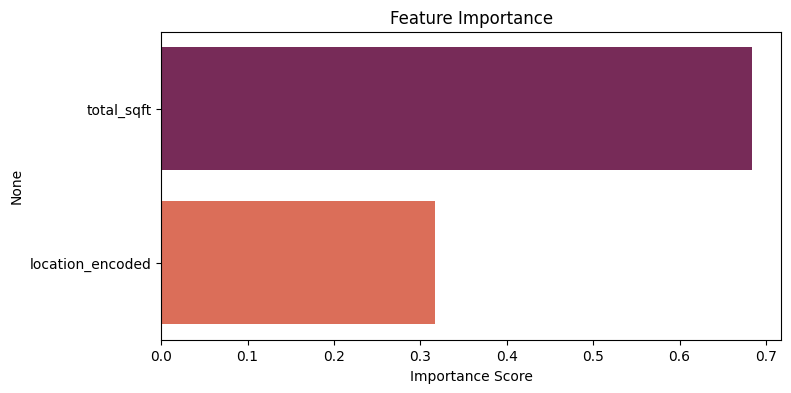

In [26]:
print("\nAnalyzing feature importance...")

feature_importance = model.named_steps['regressor'].feature_importances_
features = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance, y=features, palette='rocket')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

**STEP 11: PREDICTION SYSTEM**

In [29]:
def predict_land_price(location, total_sqft):
    """Predict land price using location and land size"""
    try:
        # Encode location
        location_encoded = encoder.transform(pd.DataFrame({'location': [location]}))

        # Create DataFrame with proper feature names
        input_data = pd.DataFrame({
            'total_sqft': [total_sqft],
            'location_encoded': [location_encoded.iloc[0, 0]]
        })

        # Make prediction
        predicted_price = model.predict(input_data)[0]

        return f"Predicted price for {total_sqft} sqft in {location}: ₹{predicted_price:.2f} lakhs"
    except Exception as e:
        return f"Error: {str(e)}"

**STEP 12: EXAMPLE PREDICTIONS**

In [30]:
print("\nExample Predictions:")
print(predict_land_price('Whitefield', 1200))     # Prime area
print(predict_land_price('Electronic City', 1500))# Tech hub
print(predict_land_price('Yelahanka', 2000))      # Suburban area


Example Predictions:
Predicted price for 1200 sqft in Whitefield: ₹58.29 lakhs
Predicted price for 1500 sqft in Electronic City: ₹77.86 lakhs
Predicted price for 2000 sqft in Yelahanka: ₹114.37 lakhs


**STEP 13: EVALUATION METRICS**

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"- RMSE (Error Margin): ₹{rmse:.2f} lakhs")
print(f"- MAE (Avg. Error): ₹{mae:.2f} lakhs")
print(f"- R² (Variance Explained): {r2:.2%}")


Model Evaluation:
- RMSE (Error Margin): ₹63.83 lakhs
- MAE (Avg. Error): ₹30.94 lakhs
- R² (Variance Explained): 80.86%
